# Energy forecasting

## Looking at national grid market close price forecasting based on Oxford weather! Calculate monthly average price and relate this to monthly metrics of the weather: Tmin, Tmax, Tmean, Rain(cm).

## [Historical weather data for Oxford](https://github.com/alanjones2/uk-historical-weather/blob/main/data/Oxford.csv)

In [1]:
# importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

In [2]:
# Importing and cleaning data- daily stock prices have been aggregated monthly to match weather data

# x input data
weather = pd.read_csv('Oxford' +'.csv', index_col = 'Date',parse_dates=True)
weather = weather[1718: ]
weather = weather[['Tmax', 'Tmin', 'Tmean', 'Sun','AF']]
weather = weather[weather["Tmax"].isnull() == False]
weather = weather[weather["Tmin"].isnull() == False]
weather = weather[weather["Tmean"].isnull() == False]
weather = weather[weather["Sun"].isnull() == False]
weather = weather[weather["AF"].isnull() == False]
weather = weather.reset_index()

# y input data
stock = pd.read_csv('NG.L' +'.csv',index_col = 'Date', parse_dates=True)
days_into_month = stock.index[-1].day
stock = stock[6:-days_into_month].resample('M').mean()
stock = stock.reset_index()

# merging to ensure null rows are excluded from both x and y
res = pd.merge(weather.assign(grouper=weather['Date'].dt.to_period('M')),
               stock.assign(grouper=stock['Date'].dt.to_period('M')),
               how='left', on='grouper')
res = res[['Date_x', 'Tmax', 'Tmin', 'Tmean', 'Sun', 'AF','Close']]
res = res.rename(columns={'Date_x': 'Date'})

In [3]:
# Creating data
features = res.shape[1]-2
N = len(res)
X = np.zeros((N, features))
Y = np.zeros((N,1))

i = 0
while i < N:
    X[i,:] = res.loc[i, ['Tmax', 'Tmin','Tmean', 'Sun', 'AF']].values.tolist()
    Y[i] = res['Close'].values[i]
    i+=1

train_size = int(len(res)*0.8)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]





In [4]:
# Generating weights and biases (normally distributed)
number_hidden_neurons = 50
input_weights = np.random.normal(0, 0.5, size=(features, number_hidden_neurons))
biases = np.random.normal(0, 1, size=(number_hidden_neurons))

# Activation function (RELU function here)
def activation(x):     
    return np.maximum(x, 0, x)

# fitting
def fit(x):
    G = np.dot(x, input_weights) + biases
    H = activation(G)
    return H

# ELM formula tells us that y = B H implies B = H^-1 y
output_weights = np.dot(pinv(fit(x_train)), y_train)

# Prediction
def predict(x):
    out = np.dot(fit(x), output_weights)

    return out

prediction = predict(x_test)




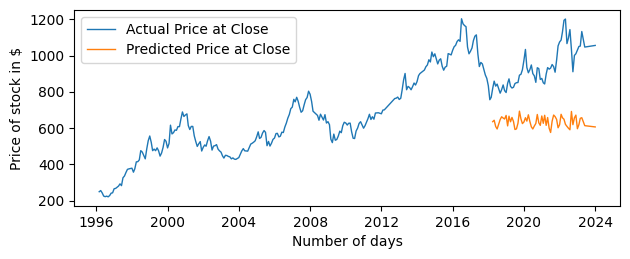

In [5]:
#Plotting_data
fig = plt.figure()

#Plot price at close
ax1 = fig.add_subplot(211, xlabel ='Number of days', ylabel='Price of stock in $')
ax1.plot(res['Date'][:], Y, lw=1.0, label = 'Actual Price at Close')

# Plot predictions
ax1.plot(res['Date'][train_size:], prediction, lw=1.0, label = 'Predicted Price at Close')
ax1.legend()

plt.tight_layout()
plt.show()

## Don't need RMSE to see that this doesn't work.